# Evaluate hint effects on final scores

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import pickle as pkl
import pandas as pd
from pandas import DataFrame as df
from collections import defaultdict
import scipy.stats as stats
import numpy as np

## Load Data

In [2]:
hw_df = pd.read_pickle('../data/pkl_data/hw_data.pkl')
hints_df = pd.read_pickle('../data/pkl_data/hint_feature_df.pkl')

In [3]:
### Add hint count for each assignment
hint_count_ids = [c for c in hints_df.columns if len(c) == 3 and c[2] == 'hint_count']
for h in hint_count_ids:
    if (h[0], 'hint_count') not in hints_df.columns:
        hints_df[(h[0], 'hint_count')] = hints_df[h]
    else:
        hints_df[(h[0], 'hint_count')] += hints_df[h]

In [4]:
cols = hw_df.columns

In [5]:
prob_list = list(set([(c[0],c[1]) for c in cols if len(c)==3]))

In [7]:
final_df = pd.read_pickle('../data/pkl_data/final_data.pkl')
weak_final_df = final_df[final_df['Total Score'] <= final_df['Total Score'].mean()]
strong_final_df = final_df[final_df['Total Score'] > final_df['Total Score'].mean()]
hints_df['Total Score'] = final_df['Total Score']
weak_hint_df = hints_df[hints_df['Total Score']  <= final_df['Total Score'].mean()]
strong_hint_df = hints_df[hints_df['Total Score']  > final_df['Total Score'].mean()]

In [8]:
final_df.columns

Index([u'Total Score', u'Submission Time', u'1: Combinatorics',
       u'2: Two Pairs', u'3.1: Part 1-3', u'3.2: Part 4-6',
       u'4: Color-blindness', u'5: CDF', u'6.1: Markov', u'6.2: Chebyshev',
       u'7: True/False', u'8.1: Distribution of X', u'8.2: Distribution of Y',
       u'8.3: Relationship between X and Y', u'9.1: alpha = 2',
       u'9.2: alpha = 3', u'9.3: alpha = 4', u'11: Hypothesis Testing',
       u'strong', u'weak', u'mid', u'group', u'10: Poisson', u'ID'],
      dtype='object')

## Create final problem to homework problems mapping

In [9]:
def pro_score_mapping(fi_df, hi_df):
    hi_df['1:Comb'] = fi_df['1: Combinatorics']/9.
    hi_df['2:Poker'] = fi_df['2: Two Pairs']/10.
    hi_df['3:StarBars'] = (fi_df['3.1: Part 1-3']+final_df['3.2: Part 4-6'])/6.
    hi_df['4:CondProb'] = fi_df['4: Color-blindness']/5.
    hi_df['5:CDF'] = fi_df['5: CDF']/15.
    hi_df['6:Markov'] = fi_df['6.1: Markov']/5.
    hi_df['6:Chebyshev'] = fi_df['6.2: Chebyshev']/5.
    hi_df['8:ContiTable'] = (fi_df['8.1: Distribution of X']+final_df['8.2: Distribution of Y']+final_df['8.3: Relationship between X and Y'])/10.
    hi_df['9:HeavyLightTail'] = (fi_df['9.1: alpha = 2'] + final_df['9.2: alpha = 3'] + final_df['9.3: alpha = 4'])/10.
    hi_df['10:Poisson'] = fi_df['10: Poisson'] / 10.
    hi_df['11:Hypothesis'] = fi_df['11: Hypothesis Testing']/5.

In [14]:
pro_map = {}
#pro_map['1:Comb'] = [('2','12'), ('3','1'), ('3','2'), ('3','3'), ('3','5'), ('3','6'), ('3','7')]
#pro_map['3:StarBars'] = [('3','8'), ('3','9')]
pro_map['4:CondProb'] = [('4','1'), ('4','2')]
pro_map['5:CDF'] =  [('5','1'), ('5','2'), ('5','3'), ('5','4')]
pro_map['6:Markov'] = [('6','4')]
pro_map['6:Chebyshev'] = [('6','6')]
pro_map['8:ContiTable'] = [('6','2'), ('6','3')]
pro_map['10:Poisson'] = [('8','3'), ('8','4'), ('8','5'), ('8','6')]

## Get final score statistics

In [58]:
### Look at each final problem
def stats_between_dfs(case_df, control_df, pro_name):
    ca = len(case_df)
    co = len(control_df)
    if ca == 0 or co == 0:
        print "ERROR: Empty dataframe passed in..."
        return
    
    case_mean = case_df[pro_name].mean()
    control_mean = control_df[pro_name].mean()
    case_std = case_df[pro_name].std()
    control_std = control_df[pro_name].std()
    
    t,p = stats.ttest_ind(case_df[pro_name], control_df[pro_name])
    return p, case_df[pro_name], control_df[pro_name]

def final_p(mapping, pro_name, hi_df):
    p = [(t[0], t[1], 'hint_count') for t in mapping[pro_name]]
    assi = list(set([(t[0], 'assign') for t in mapping[pro_name]]))

    hi_df[pro_name+'_hint_count'] = hi_df[p].sum(axis=1)
    hi_df[pro_name+'_assign'] = hi_df[assi].sum(axis=1)

    case_df = hi_df[hi_df[pro_name+'_hint_count'] > 0 & (hi_df[pro_name+'_assign'] != 0)]
    control_df = hi_df[(hi_df[pro_name+'_hint_count'] > 0) & (hi_df[pro_name+'_assign'] == 0)]
    
    #print "{0} students with hints".format(len(Comb_h_df))
    #print "{0} students with no hint assigned".format(len(Comb_nh_df))
    #print "{0} students ignore hints".format(len(Comb_ns_df))
    return stats_between_dfs(case_df, control_df, pro_name)

def get_means_p(problems, fi_df, hi_df):
    p_vals = defaultdict(float)
    case_dict = defaultdict(list)
    control_dict = defaultdict(list)
    pro_score_mapping(fi_df, hi_df)
    for k in sorted(problems):
        p, case, control = final_p(pro_map, k, hi_df)
        p_vals[k] = p
        case_dict[k] = case
        control_dict[k] = control
    return p_vals, case_dict, control_dict

In [59]:
p_vals, case, control = get_means_p(pro_map, final_df, hints_df)

    (8, assign)
ID             
247         NaN
336         NaN
109         NaN
280         NaN
221         NaN
105         NaN
308           1
152           1
162           1
147           0
199         NaN
254         NaN
332           0
185           1
93          NaN
121           1
261           1
153         NaN
190           1
101           0
242         NaN
204           1
220           0
65          NaN
79          NaN
131           1
181           0
315         NaN
231           1
164           1
..          ...
237           0
149           0
240           0
184           0
126           0
59            1
250           0
287           1
209           1
60            0
307           1
135           0
320           0
296           0
258           0
167           0
133           0
42            0
234           1
206           0
91            1
46            0
81            1
214           0
150           1
257           0
330           1
226           1
249           0
314     

## Plot results

In [43]:
from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes
from math import log10, floor

def fig_setting(base_size):
    SMALL_SIZE = base_size
    MEDIUM_SIZE = base_size+2
    BIGGER_SIZE = base_size+4
    plt.figure(figsize=(10,8))
    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    return plt

def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['fliers'][0], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
    setp(bp['fliers'][1], color='red')
    setp(bp['medians'][1], color='red')
    
def box_plots(problems, p_vals, control_fea, case_fea, title, ylabel, ymax):
    fig = fig_setting(16)
    fig.figure(figsize=(10,8))
    ax = axes()
    hold(True)

    pros = []
    m = 0
    for p in problems:
        pv = p_vals[p]
        if pv:
            if pv > 0.01:
                pv = round(pv, 2)
            elif pv > 0.001:
                pv = round(pv, 3)
            elif pv > 0.0001:
                pv = round(pv, 4)
            else:
                pv = '10'+str(pv)[str(pv).index('e')+1:]
            bp = boxplot([control_fea[p], case_fea[p]], positions = [m*3+1, m*3+2], widths = 0.8)#, vert=False)
            setBoxColors(bp)
            pros.append('{0},{1}'.format(p, pv))
        else:
            bp = boxplot([[],[]], positions = [m*3+1, m*3+2], widths = 0.8)#, vert=False)
            setBoxColors(bp)
            pros.append('{0}'.format(p))
        m += 1

    # set axes limits and labels
    xlim(0,len(pros)*3)
    ylim(0,ymax)
    ax.set_xticks(np.array(range(15, 15*len(pros)*2, 30))/10.)
    ax.set_xticklabels(pros, rotation='vertical')
    ax.set_title(title)
    ax.set_xlabel('Problem, P-Values')
    ax.set_ylabel(ylabel)

    # draw temporary red and blue lines and use them to create a legend
    hB, = plot([1,1],'b-')
    hR, = plot([1,1],'r-')
    legend((hB, hR),('Control', 'Case'), loc=4)
    hB.set_visible(False)
    hR.set_visible(False)
    fig.tight_layout()

In [45]:
pro_map.keys()

['5:CDF',
 '6:Chebyshev',
 '6:Markov',
 '8:ContiTable',
 '10:Poisson',
 '4:CondProb']

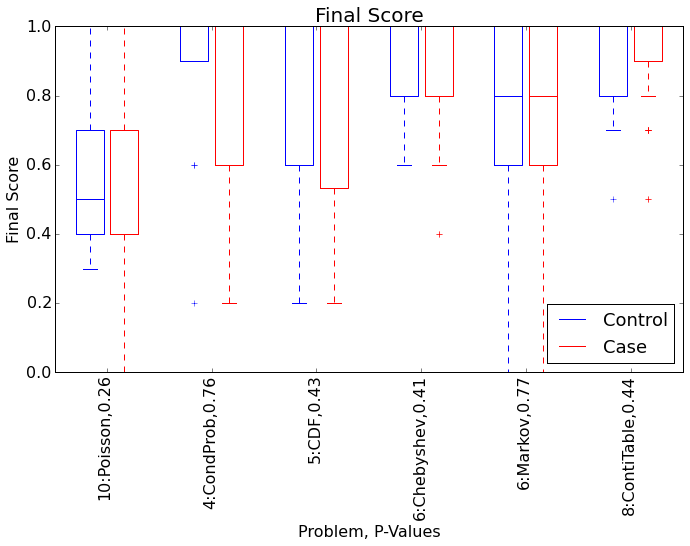

In [44]:
box_plots(sorted(pro_map.keys()), p_vals, control, case, 'Final Score', 'Final Score', 1)

In [50]:
case['6:Markov']

ID
152    0.6
171    1.0
248    1.0
72     1.0
38     0.6
255    0.6
194    0.6
92     1.0
271    1.0
281    1.0
267    0.6
118    0.8
340    1.0
111    0.0
264    0.6
145    0.6
178    1.0
333    0.6
251    1.0
170    1.0
193    0.6
277    0.6
56     0.8
99     0.6
59     0.6
60     1.0
307    0.6
258    1.0
81     1.0
214    1.0
150    1.0
Name: 6:Markov, dtype: float64

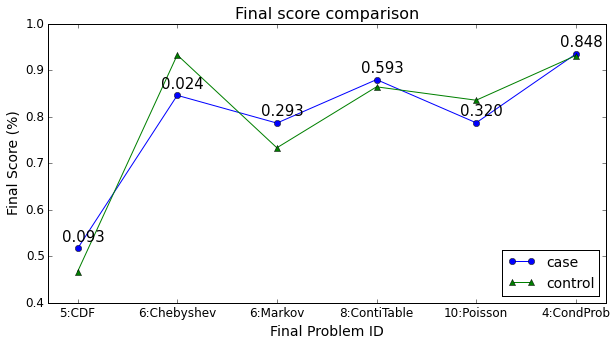

In [22]:
plt = fig_setting()
x = range(len(y_hint))
plt.xticks(x, pro_map.keys())
plot_hints(x, y_hint, y_nohint)
plt.xlabel('Final Problem ID')
plt.ylabel('Final Score (%)')
plt.title('Final score comparison')
plt.xlim((-0.3, 5.3))
for i,j,k in zip(x,y_hint,p_vals):
    plt.annotate("%.3f"%k, xy=(i, j), xytext=(-15, 7), textcoords='offset points', fontsize=15)
plt.savefig('../graphs/final_compare.png')

## Get problem statistics

In [17]:
### Look at each assignment
def stats_between_dfs_assign(h_df, noh_df, fi_pros):
    h = len(h_df)
    no_h = len(noh_df)
    if h == 0 or no_h == 0:
        print "ERROR: Empty dataframe passed in..."
        return
    
    hint_sum = h_df[fi_pros[0]]
    nh_sum = noh_df[fi_pros[0]]
    if len(fi_pros) > 1:
        for f in fi_pros[1:]:
            hint_sum = h_df[f] + hint_sum
            nh_sum = noh_df[f] + nh_sum
        hint_sum = hint_sum/len(fi_pros)
        nh_sum = nh_sum/len(fi_pros)
        
    hint_mean = hint_sum.mean()
    nh_mean = nh_sum.mean()
    hint_std = hint_sum.std()
    nh_std = nh_sum.std()
    
    t,p = stats.ttest_ind_from_stats(hint_mean, hint_std, h, nh_mean, nh_std, no_h)
    return p, hint_mean, nh_mean

def assign_p(assign_id, hi_df, mapping):
    Comb_h_df = hi_df[hi_df[assign_id, 'hint_count'] > 0]
    Comb_nh_df = hi_df[(hi_df[assign_id, 'hint_count'] == 0) & (hi_df[assign_id, 'assign'] == '0')]
    Comb_ns_df = hi_df[(hi_df[assign_id, 'hint_count'] == 0) & (hi_df[assign_id, 'assign'] != '0')]
    
    #print "{0} students with hints".format(len(Comb_h_df))
    #print "{0} students with no hint assigned".format(len(Comb_nh_df))
    #print "{0} students ignore hints".format(len(Comb_ns_df))
    st, h_mean, nh_mean = stats_between_dfs_assign(Comb_h_df, Comb_nh_df, mapping[assign_id])
    return st, h_mean, nh_mean

def get_assign_means_p(assigns, fi_df, hi_df):
    p_vals = []
    h_means = []
    nh_means = []
    pro_score_mapping(fi_df, hi_df)
    for k in sorted(assigns):
        #print k
        p, h_mean, nh_mean = assign_p(k, hi_df, fin_map)
        p_vals.append(p)
        h_means.append(h_mean)
        nh_means.append(nh_mean)
    return p_vals, h_means, nh_means

In [18]:
p_vals, y_hint, y_nohint = get_assign_means_p(fin_map, final_df, hints_df)

## Plot results

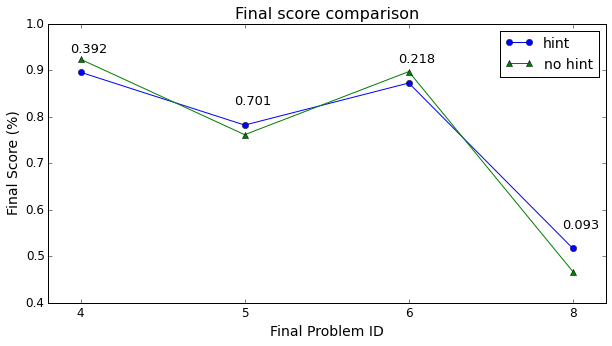

In [19]:
plt = fig_setting()
x = range(len(y_hint))
plt.xticks(x, sorted(fin_map))
plot_hints(x, y_hint, y_nohint)
plt.xlabel('Final Problem ID')
plt.ylabel('Final Score (%)')
plt.xlim((-0.2, 3.2))
plt.legend(loc=1)
for i,j,k in zip(x,y_hint,p_vals):
    plt.annotate("%.3f"%k, xy=(i, j), xytext=(-10, 20), textcoords='offset points', fontsize=13)
plt.title('Final score comparison')
#plt.savefig('../graphs/final_compare_assign.png')

## Correlation

In [20]:
def corr_stats(h_df, noh_df, final_pro_name, print_enabled=True):
    """
    h_df: dataframe with hints
    noh_df: dataframe with no hint
    final_col: name of final column
    """
    h = len(h_df)
    no_h = len(noh_df)
    if h == 0 or no_h == 0:
        return
    
    hint_pro = h_df[final_pro_name+'_HintCount'].tolist()
    
    hint_fi = h_df[final_pro_name].tolist()
    nh_fi = noh_df[final_pro_name].tolist()
    
    if(print_enabled):
        print final_pro_name
        print h
        print no_h
        print 'with_hint: ', h/(h+no_h*1.)
        print 'with_no_hint: ', no_h/(h+no_h*1.)
        print '\n\n'
    return stats.pearsonr(hint_pro, hint_fi)

def corr_p_val():
    all_pros = []
    for pro_name in sorted(pro_map.keys()):
        print pro_name
        p = [(t[0], t[1], 'hint_count') for t in pro_map[pro_name]]
        hints_df[pro_name+'_HintCount'] = hints_df[p].sum(axis=1)
        h_df = hints_df[hints_df[pro_name+'_HintCount'] > 0]
        nh_df = hints_df[hints_df[pro_name+'_HintCount'] == 0]
        st = corr_stats(h_df, nh_df, pro_name, False)
        all_pros.append(st)
    return all_pros

In [21]:
corr_p_val()

10:Poisson
4:CondProb
5:CDF
6:Chebyshev
6:Markov
8:ContiTable


[(-0.047626555316083348, 0.64672169908626809),
 (-0.015824678797446198, 0.92382584002882906),
 (-0.055773753559113438, 0.45708858781784611),
 (0.0908988021562947, 0.48974174999733355),
 (-0.49090578975894344, 0.005045901062410766),
 (-0.051240567128469597, 0.56568940825598135)]

In [22]:
p = [(t[0], t[1], 'hint_count') for t in prob_list if int(t[0])>3]
hints_df['Total_HintCount'] = hints_df[p].sum(axis=1)
hints_df['Final_Score'] = final_df['Total Score']
h_df = hints_df[hints_df['Total_HintCount'] > 0]
h_fi = h_df['Final_Score'].tolist()
h_hw = h_df['Total_HintCount'].tolist()
stats.pearsonr(h_hw, h_fi)

(-0.1863001998374289, 0.0042409267823381551)

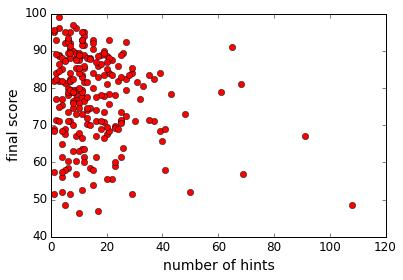

In [23]:
plt.xlabel('number of hints')
plt.ylabel('final score')
plt.plot(h_hw, h_fi, 'ro')